In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import time
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from pythonlibs.torch_lib1 import *
from torchviz import make_dot
from torchinfo import summary
import os

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [42]:
# matplotlibの初期設定
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 14

In [3]:
# transformerの定義

test_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), # 学習済みモデルの学習時のサイズに合わせるためくり抜く
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),　# crop -> resize : cropにランダム要素
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing()
])

In [6]:
data_dir = 'hidden_data/hymenoptera_data/'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')


print(train_dir)
print(test_dir)

classes = ['ants', 'bees']


hidden_data/hymenoptera_data/train
hidden_data/hymenoptera_data/val


In [8]:
# データセット
train_data = datasets.ImageFolder(train_dir, train_transform)
train_data2 = datasets.ImageFolder(test_dir, train_transform)

test_data = datasets.ImageFolder(test_dir, test_transform)

In [11]:
# データセットの確認
print(f'データ件数：{len(train_data)}')
print(f'データ件数：{len(test_data)}')


データ件数：244
データ件数：153


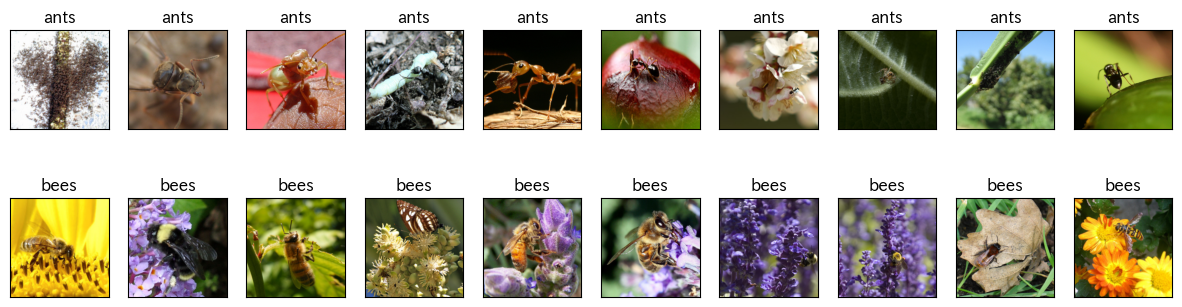

In [22]:
# 検証データの最初の10件と最後の10件のデータを見る

plt.figure(figsize=(15,4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    image, label= test_data[i]
    img = np.transpose(image.numpy(), (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    image, label= test_data[-i-1]
    img = np.transpose(image.numpy(), (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [23]:
# データローダー
batch_size=10

train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False) 

# イメージ表示用
train_loader2 = DataLoader(train_data, batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, batch_size=50, shuffle=True) # shuffleを入れることで偏りなくant, beeを表示する


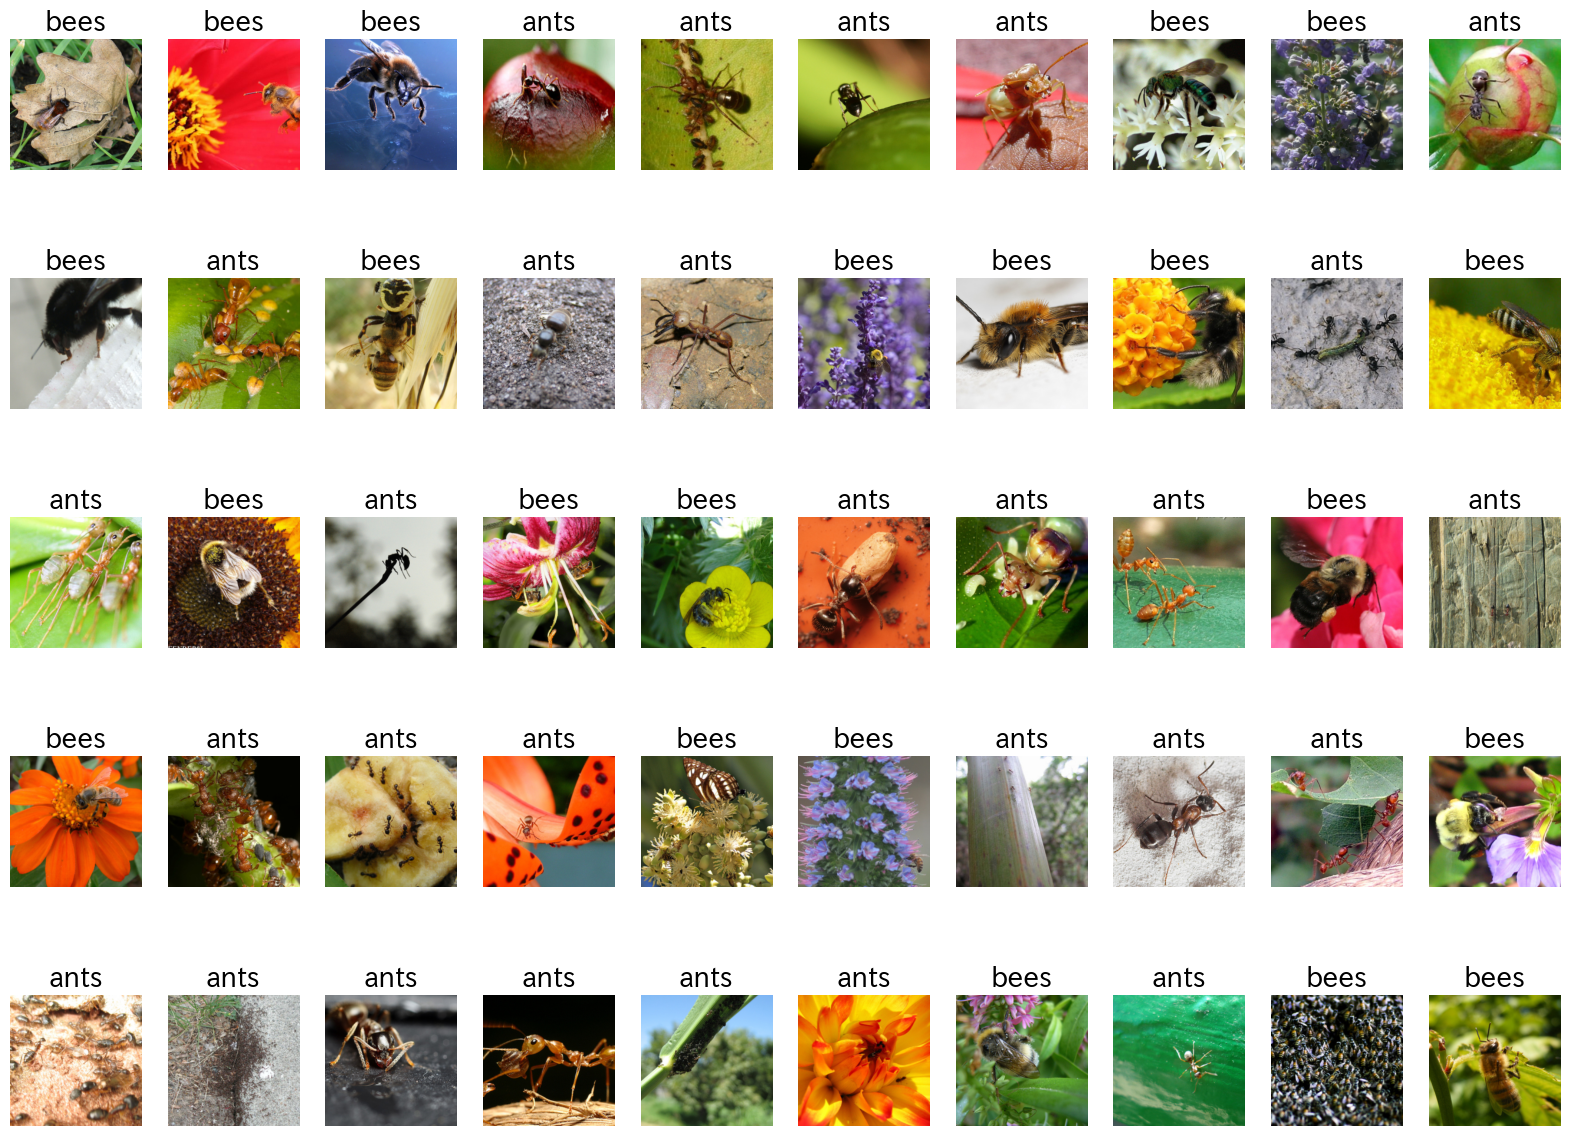

In [32]:
# 検証データ（５０件）
torch_seed()

show_images_labels(test_loader2, classes, None, None)

## ファインチューニング

In [47]:
# finetuning

# データのロード
net = models.vgg19_bn(weights='IMAGENET1K_V1')

torch_seed()

# 最終レイヤーの付け替え
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# adaptiveの取り外し
net.avgpool = nn.Identity()

# GPUを利用
net = net.to(device)

lr = 0.001
optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()

history = np.zeros((0, 5))

In [48]:
num_epoch = 5
history = fit(net, optimizer, criterion, num_epoch, train_dataloader, test_dataloader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.42649 acc: 0.78689 val_loss: 0.10943, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.18249 acc: 0.92213 val_loss: 0.13160, val_acc: 0.96732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.23100 acc: 0.91803 val_loss: 0.11618, val_acc: 0.96732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.13759 acc: 0.93443 val_loss: 0.14820, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.15287 acc: 0.92623 val_loss: 0.12153, val_acc: 0.95425


初期状態: 損失: 0.10943 精度: 0.96078
最終状態: 損失: 0.12153 精度: 0.95425


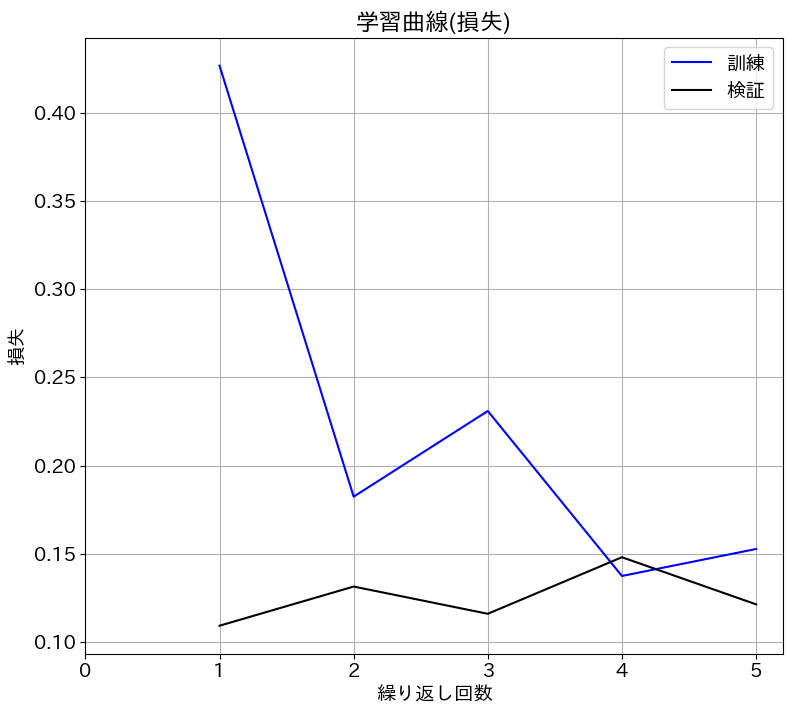

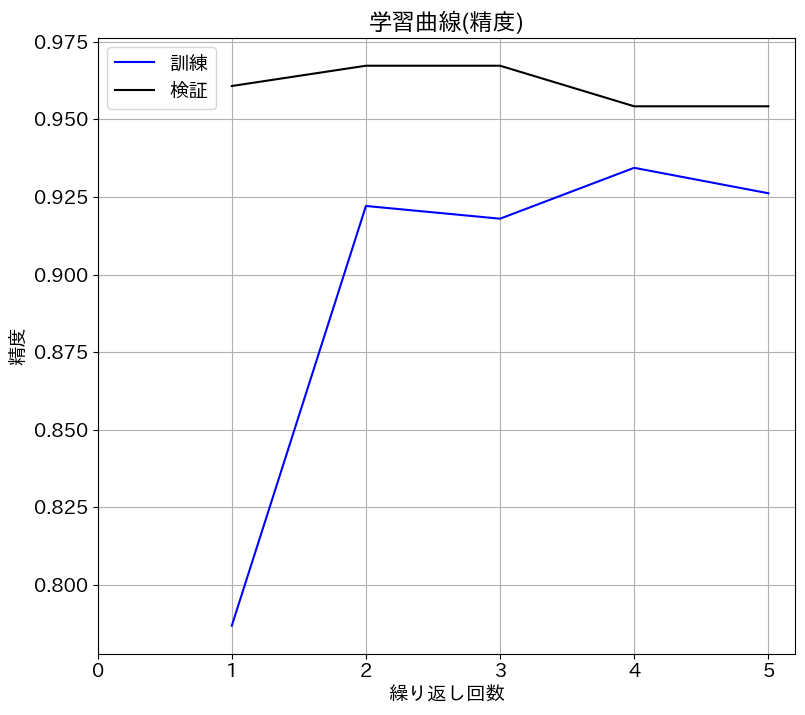

In [49]:
evaluate_history(history)

## 転移学習

In [58]:
# 転移学習

# データのロード
net = models.vgg19_bn(weights='IMAGENET1K_V1')

# パラメータを固定 -> 勾配なし
for param in net.parameters():
    param.requires_grad = False

torch_seed()

# 最終レイヤーの付け替え
# このレイヤーのみ勾配を計算することになる。（転移学習）
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# adaptiveの取り外し
net.avgpool = nn.Identity()

# GPUを利用
net = net.to(device)

lr = 0.001
optimizer = optim.SGD(net.classifier[6].parameters(), lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()

history = np.zeros((0, 5))

In [59]:
num_epoch = 5
history = fit(net, optimizer, criterion, num_epoch, train_dataloader, test_dataloader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.44875 acc: 0.78279 val_loss: 0.13660, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.22087 acc: 0.91803 val_loss: 0.12674, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.24330 acc: 0.90164 val_loss: 0.11816, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.20167 acc: 0.90164 val_loss: 0.12738, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.20411 acc: 0.88934 val_loss: 0.11902, val_acc: 0.96078


初期状態: 損失: 0.13660 精度: 0.96078
最終状態: 損失: 0.11902 精度: 0.96078


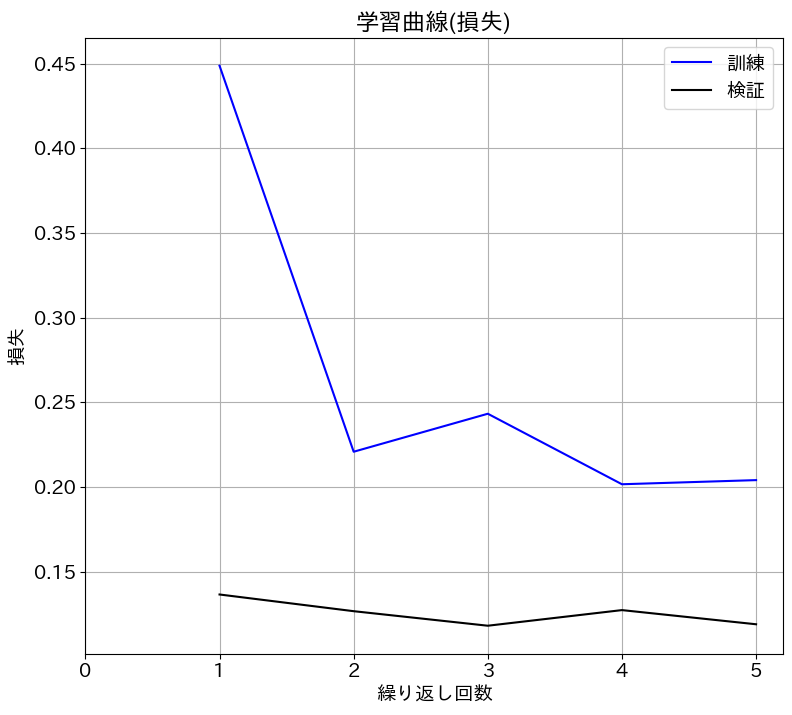

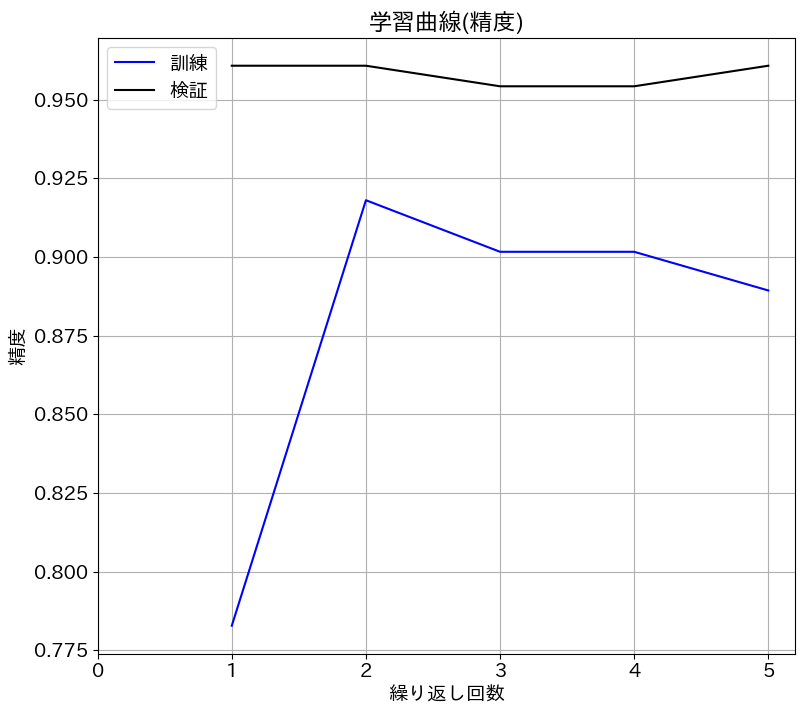

In [61]:
evaluate_history(history)

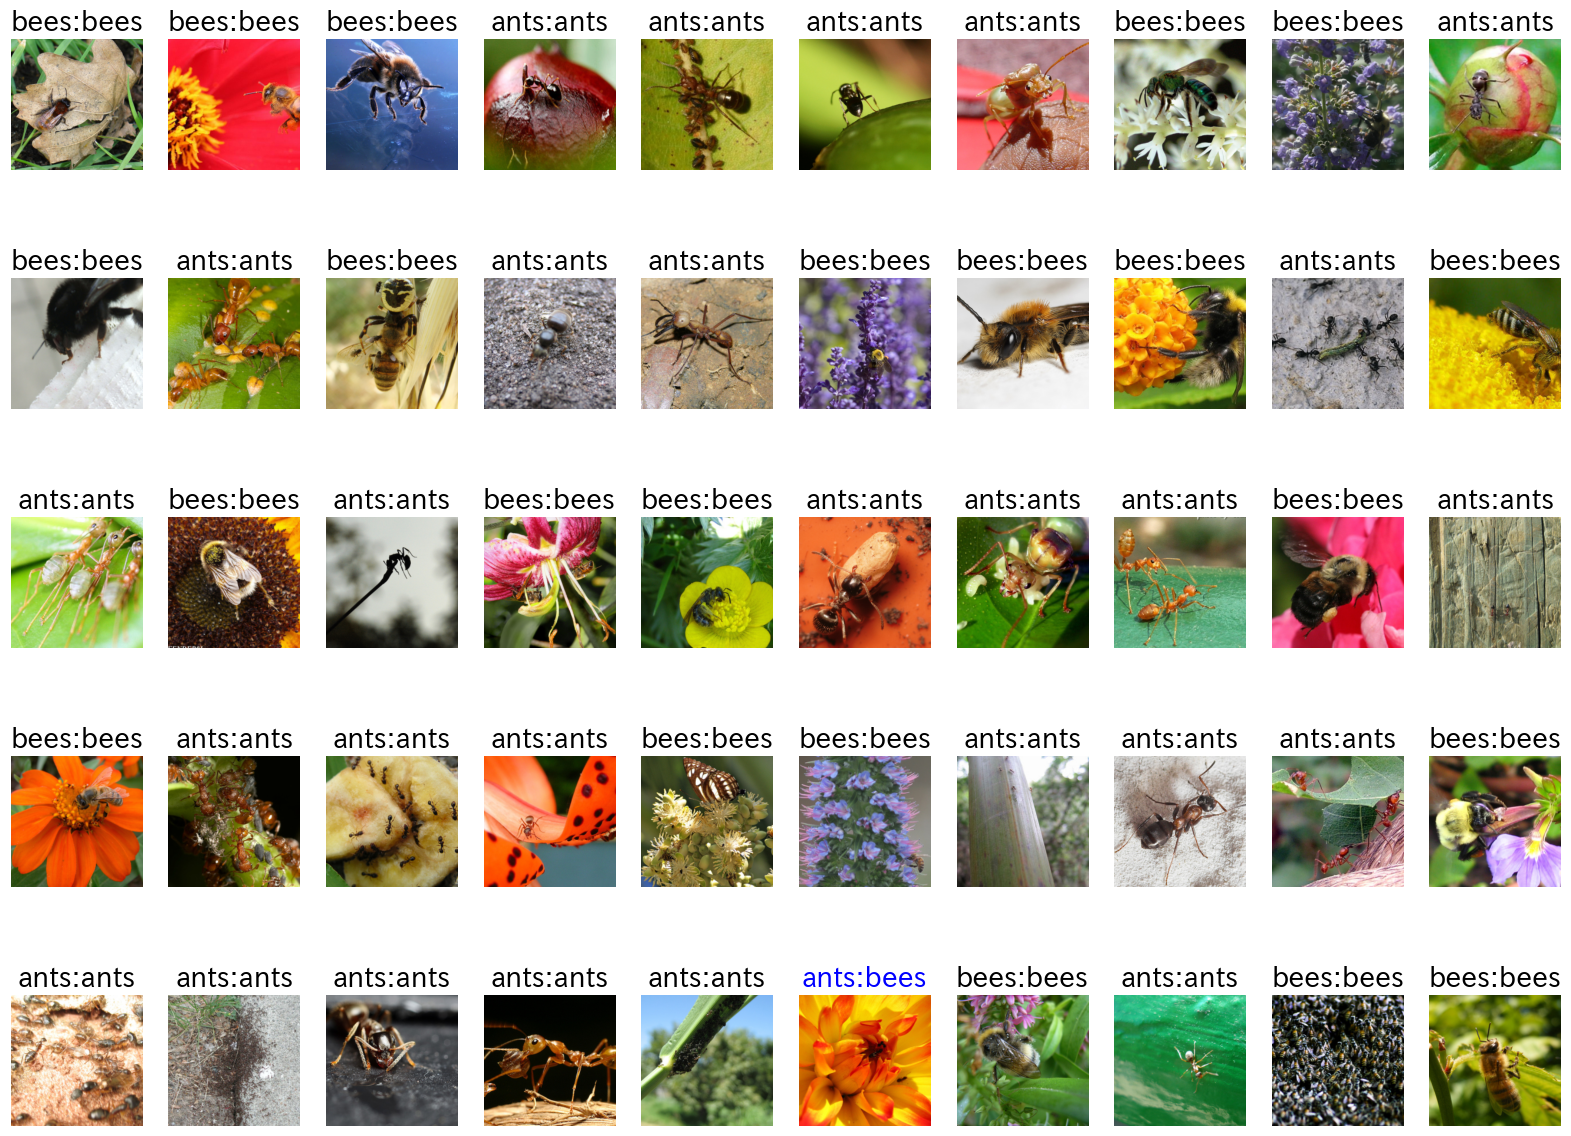

In [62]:
torch_seed()

show_images_labels(test_loader2, classes, net, device)

# ユーザー定義データの場合

In [106]:
# transformerの定義

test_transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.CenterCrop(224), # 学習済みモデルの学習時のサイズに合わせるためくり抜く
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing()
])

In [107]:
data_dir = 'hidden_data/dog_wolf/'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

# データセット
train_data = datasets.ImageFolder(train_dir, train_transform)
train_data2 = datasets.ImageFolder(train_dir, test_transform)

test_data = datasets.ImageFolder(test_dir, test_transform)

In [108]:
# データ件数確認

print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

学習データ: 40件
検証データ: 10件


In [109]:
# dataloader

batch_size = 5

train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
train_dataloader2 = DataLoader(train_data2, batch_size=40, shuffle=False)

test_dataloader = DataLoader(test_data, batch_size, shuffle=False)
test_dataloader2 = DataLoader(test_data, batch_size=10, shuffle=True)


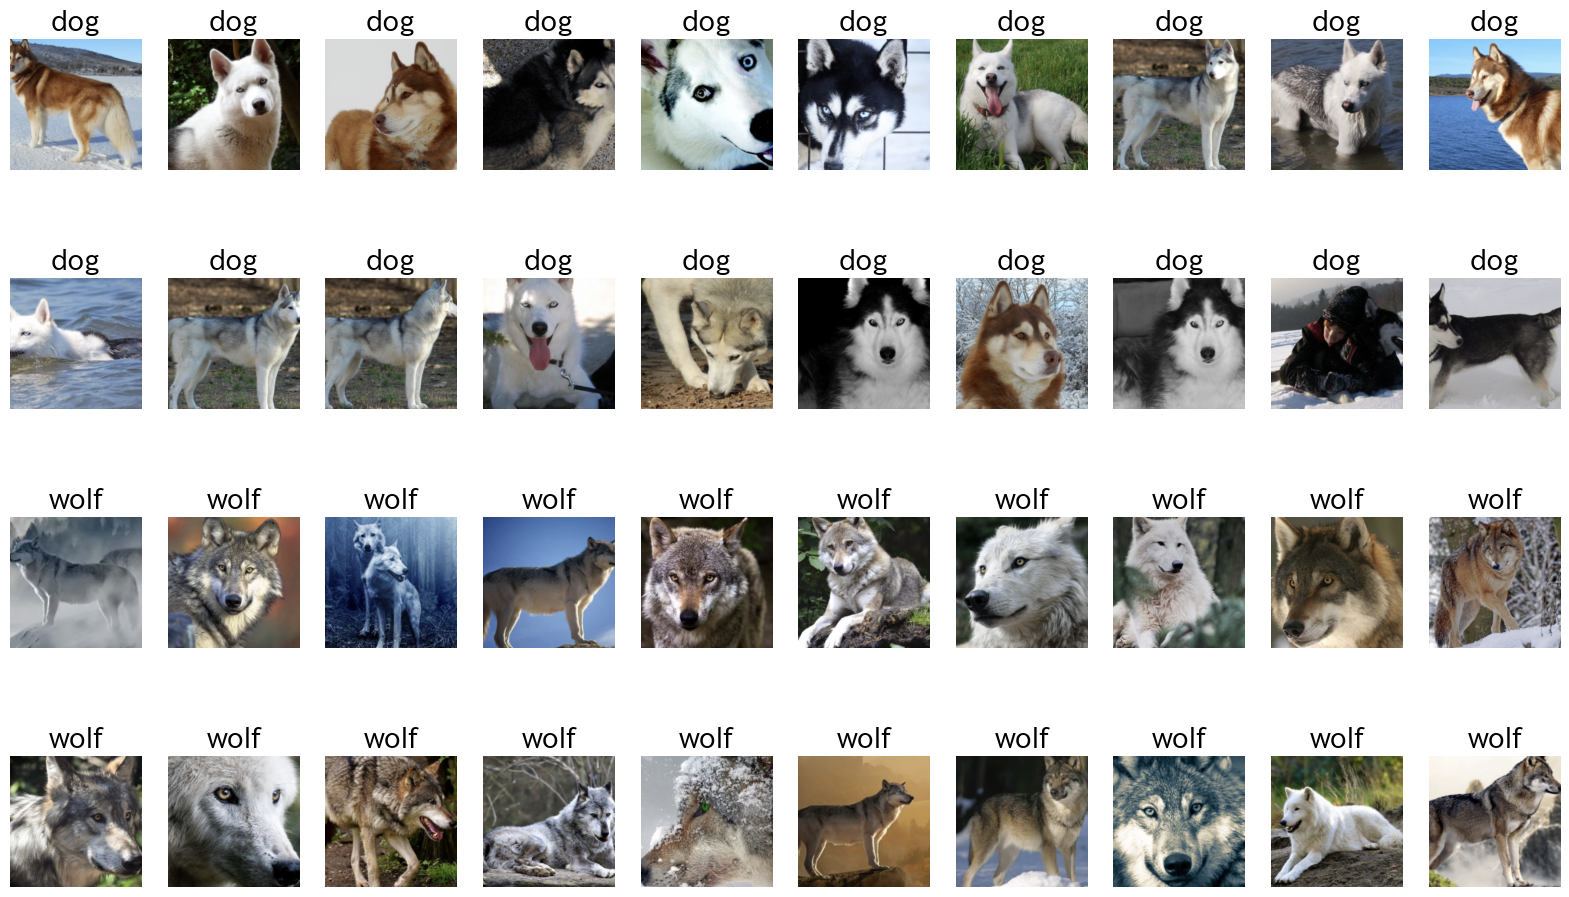

In [94]:
# 訓練データの表示

show_images_labels(train_dataloader2, classes, None, None)

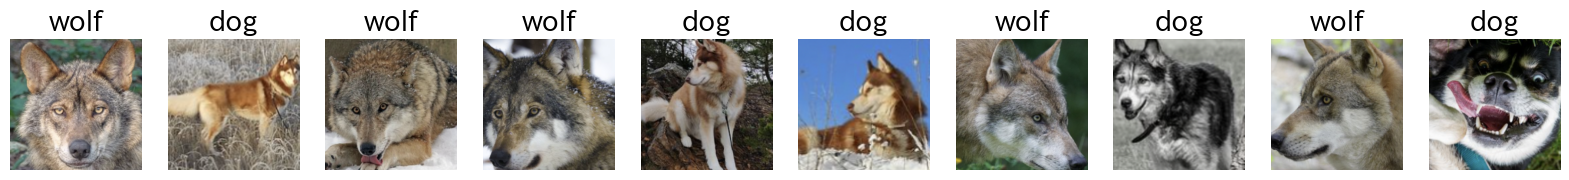

In [95]:
# test ver
torch_seed()
show_images_labels(test_dataloader2, classes, None, None)

In [110]:
# 転移学習

# データのロード
net = models.vgg19_bn(weights='IMAGENET1K_V1')

# パラメータを固定 -> 勾配なし
for param in net.parameters():
    param.requires_grad = False

torch_seed()

# 最終レイヤーの付け替え
# このレイヤーのみ勾配を計算することになる。（転移学習）
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# adaptiveの取り外し
net.avgpool = nn.Identity()

# GPUを利用
net = net.to(device)

lr = 0.001
optimizer = optim.SGD(net.classifier[6].parameters(), lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()

history = np.zeros((0, 5))

In [111]:
num_epoch = 10
history = fit(net, optimizer, criterion, num_epoch, train_dataloader, test_dataloader, device, history)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.61723 acc: 0.65000 val_loss: 0.38927, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.37922 acc: 0.85000 val_loss: 0.24463, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.19884 acc: 0.92500 val_loss: 0.28781, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.21072 acc: 0.92500 val_loss: 0.19936, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.09178 acc: 0.97500 val_loss: 0.14848, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.10720 acc: 0.97500 val_loss: 0.20909, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.15090 acc: 0.95000 val_loss: 0.18156, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.21594 acc: 0.92500 val_loss: 0.15915, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.05429 acc: 1.00000 val_loss: 0.13820, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.22085 acc: 0.92500 val_loss: 0.15931, val_acc: 1.00000


初期状態: 損失: 0.38927 精度: 1.00000
最終状態: 損失: 0.15931 精度: 1.00000


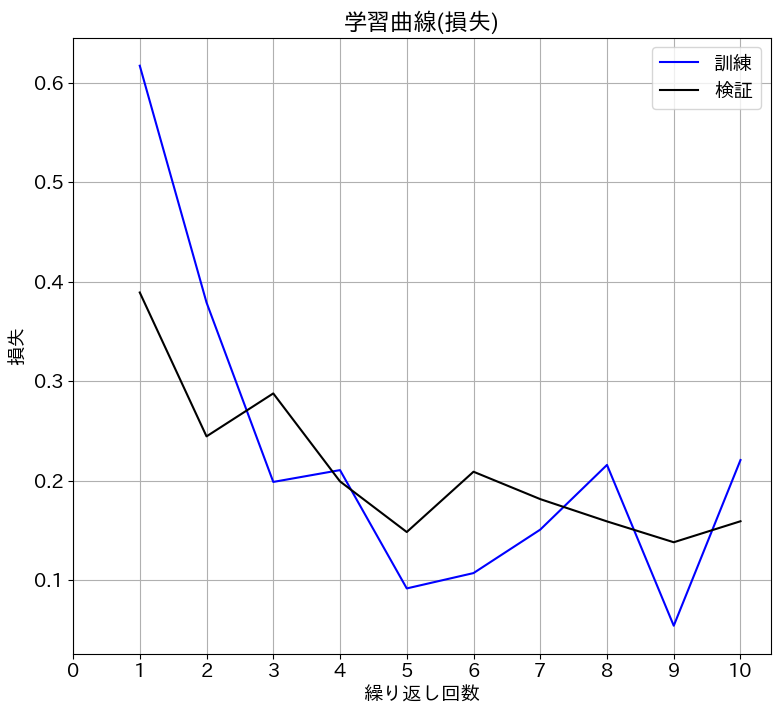

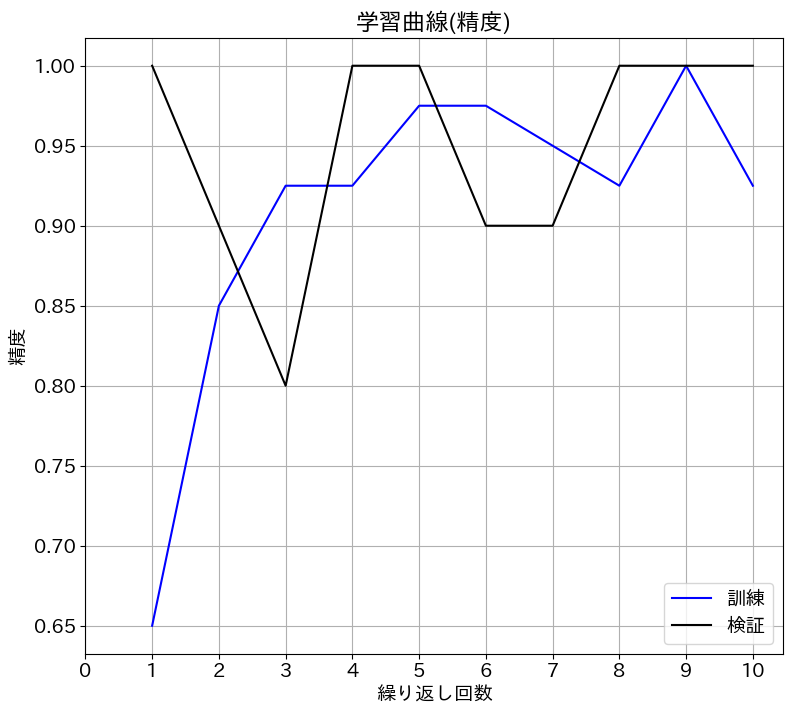

In [112]:
evaluate_history(history)

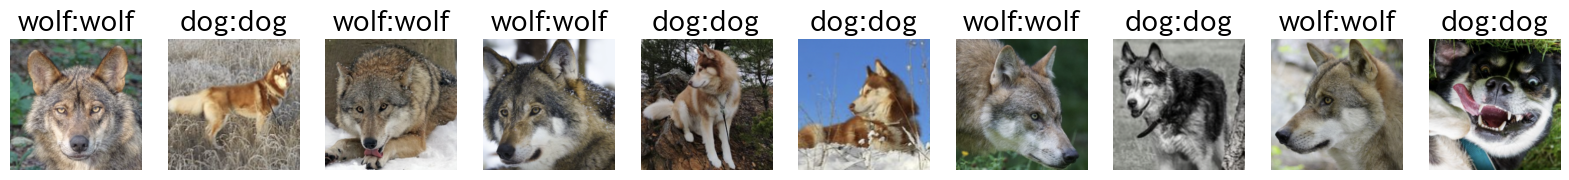

In [114]:
torch_seed()
show_images_labels(test_loader2, classes, net, device)